# Modeling Notes for Final Report

- `model.py` is used to build out the models, and it calls on `model_constants.py` to organize the code and produce a dataframe with model results.

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
import model

## Preparing the dataframe for modeling
- Data needs to be encoded, and this needs to be done to the whole dataframe
- After the whole dataframe is prepared, it is split again into the train/validate/test

In [2]:
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
df_in = model.prepare_model_df(df_in) # DO NOT USE THIS LINE IF NOT MODELING
train, validate, test = prepare.split_data(df_in)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((40311, 4696), (6719, 4696), (6719, 4696))

## Making a baseline model
- Two baseline models are made, one using the mean and the other using the median

In [3]:
model.make_baseline_model(train, validate, return_df=True)

,model,train_RMSE,train_r2,train_explained_variance,validate_RMSE,validate_r2,validate_explained_variance
0,baseline_mean,81.702292,0.000000,0.0,95.169050,-0.000005,-4.440892e-16
1,baseline_median,81.938236,-0.005784,0.0,95.357542,-0.003970,0.000000e+00


## Building Regression Models on Train and Validate

In [4]:
metrics_df, train_predictions, validate_predictions = model.model_loop(train, validate)

In [5]:
pd.DataFrame(metrics_df).sort_values('validate_RMSE')

,model,train_RMSE,train_r2,train_explained_variance,validate_RMSE,validate_r2,validate_explained_variance
2,DecisionTreeRegressor,2.485706e-18,1.000000,1.000000,5.248324e+01,6.958750e-01,6.960382e-01
10,RandomForestRegressor,2.273766e+01,0.922550,0.922600,6.856514e+01,4.809400e-01,4.811722e-01
9,KNeighborsRegressor_weighted,0.000000e+00,1.000000,1.000000,7.499072e+01,3.790940e-01,3.791740e-01
8,KNeighborsRegressor,4.477918e+01,0.699611,0.699643,7.557161e+01,3.694374e-01,3.695111e-01
3,LinearSVR,7.984952e+01,0.044840,0.048356,9.386594e+01,2.719266e-02,2.967521e-02
7,RadiusNeighborsRegressor_weighted,0.000000e+00,1.000000,1.000000,9.419789e+01,2.029999e-02,2.048933e-02
6,RadiusNeighborsRegressor,8.093229e+01,0.018760,0.019074,9.437445e+01,1.662386e-02,1.678107e-02
5,LassoLars,8.170229e+01,0.000000,0.000000,9.516905e+01,-5.200353e-06,0.000000e+00
0,baseline_mean,8.170229e+01,0.000000,0.000000,9.516905e+01,-5.200353e-06,-4.440892e-16
1,baseline_median,8.193824e+01,-0.005784,0.000000,9.535754e+01,-3.970362e-03,0.000000e+00


# Modeling the residuals of the decision tree regressor

In [33]:
decision_tree_predict = validate_predictions[['name', 'usd', 'DecisionTreeRegressor_predictions']]
decision_tree_predict['residual'] = decision_tree_predict['DecisionTreeRegressor_predictions'] - decision_tree_predict['usd']

Text(0.5, 1.0, 'Plot of residuals for DecisionTreeRegressor')

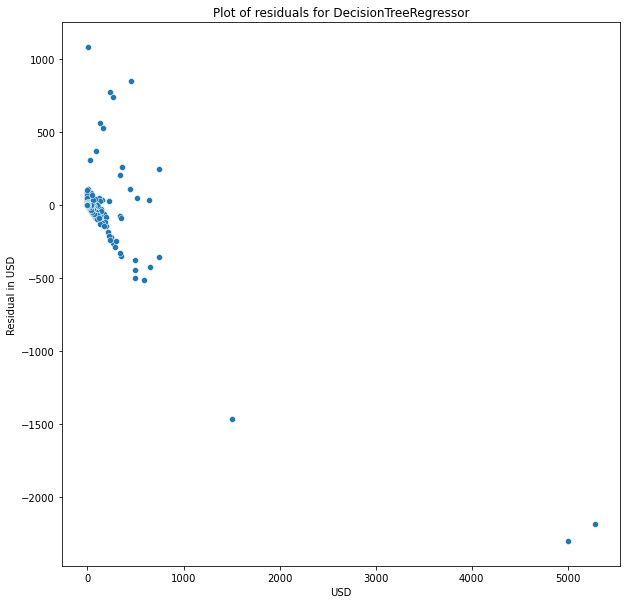

In [34]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = decision_tree_predict, x = 'usd', y = 'residual')
plt.ylabel('Residual in USD')
plt.xlabel('USD')
plt.title('Plot of residuals for DecisionTreeRegressor')

Text(0.5, 1.0, 'Plot of residuals for DecisionTreeRegressor Zoomed in to cards worth less than 20$')

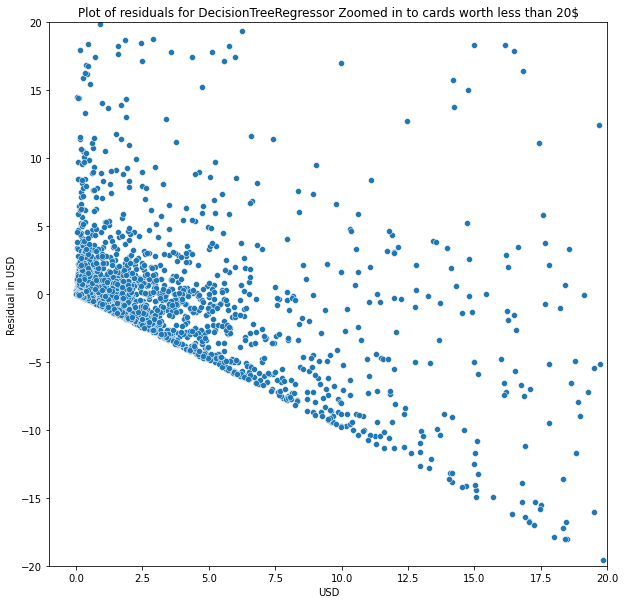

In [35]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = decision_tree_predict, x = 'usd', y = 'residual')
plt.xlim((-1, 20))
plt.ylim((-20,20))
plt.ylabel('Residual in USD')
plt.xlabel('USD')
plt.title('Plot of residuals for DecisionTreeRegressor Zoomed in to cards worth less than 20$')

In [36]:
decision_tree_predict[['residual']].describe().T

,count,mean,std,min,25%,50%,75%,max
residual,6719.0,-1.215525,52.473067,-2299.99,-0.17,-0.01,0.05,1085.5


Number of cards predicted within a dime of the actual value

In [37]:
decision_tree_predict[abs(decision_tree_predict['residual']) < 0.10].shape[0]

3285

The percentage of cards within a dime of the actual value

In [38]:
decision_tree_predict[abs(decision_tree_predict['residual']) < 0.10].shape[0]/decision_tree_predict.shape[0]

0.4889120404822146

# Key modeling takeaways
- All the models are beating baseline on the RMSE metric
- The DecisionTreeRegressor has the lowest RMSE
- While the RMSE is high for decisionTree, for many cards it is fairly close; this indicates that the error is larger for certain cards.
- The model is underpredicting cards as the actual usd price goes up
- However, 0.46 percent are within a dime of the actual value